# [Predictive Clinical Neuroscience Toolkit](https://github.com/amarquand/PCNtoolkit) 
# The Normative Modeling Framework for Computational Psychiatry Protocol
## Using Pre-trained Normative Models for Longitudinal Cortical Thickness Data Analysis

Created by [Barbora Rehák Bučková](https://twitter.com/BarboraRehak)

![Pipeline overview](Protocol_overview.png)

# Data Preparation

## Install necessary libraries & grab data files

### Step 0.
Begin by creating the conda virtual environment (if you're working on your own computer). You can follow the recommendation at the PCN toolkit [webpage](https://github.com/amarquand/PCNtoolkit). 

In [2]:
! conda create -y python==3.9 --name=PCN
! conda activate PCN

Solving environment: unsuccessful attempt using repodata from current_repodata.json, retrying with next repodata source.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 23.9.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.9.0



## Package Plan ##

  environment location: /Users/barbora/anaconda3/envs/PCN

  added / updated specs:
    - python==3.9


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    libffi-3.3                 |       hc377ac9_2         103 KB
    python-3.9.0               |h4b4120c_5_cpython        13.4 MB  conda-forge
    ------------------------------------------------------------
                                           Total:        13.5 MB

The following NEW pack

Clone the GitHub repository, it contains the necessary code and example data. Additionally, clone the repository with pretrained models

In [ ]:
# Clone the repository
! git clone --single-branch --branch LongNM https://github.com/bbuckova/PCNtoolkit-demo.git pokus
#! git clone https://github.com/predictive-clinical-neuroscience/PCNtoolkit-demo.git

In [1]:
# Here, install the PCN toolkit
! pip install pcntoolkit

  Using cached pcntoolkit-0.28-py3-none-any.whl
  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)
  Using cached nibabel-5.1.0-py3-none-any.whl (3.3 MB)
  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/88/a3/023bf03411b8d89954d028dd56dc97f5fa04f18b4cb2acf4315dfb3dfa15/scikit_learn-1.3.1-cp39-cp39-macosx_12_0_arm64.whl.metadata
  Using cached scikit_learn-1.3.1-cp39-cp39-macosx_12_0_arm64.whl.metadata (11 kB)
  Using cached bspline-0.1.1-py3-none-any.whl
  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/95/25/4178ff92b6e523c9ad48ed3822b26375d5a5173b28b75ac7c1cb640a9c94/matplotlib-3.8.0-cp39-cp39-macosx_11_0_arm64.whl.metadata
  Using cached matplotlib-3.8.0-cp39-cp39-macosx_11_0_arm64.whl.metadata (5.8 kB)
  Obtaining dependency information for numpy from https://files.pythonhosted.org/packages/b4/ca/fc1c4f8a2a4693ff437d039acf2dc93a190b9494569fbed246f535c44fc8/numpy-1.26.0-cp39-cp39-mac

In [ ]:
# Also clone the pretrained models repository and unpack the relevant models
! git clone https://github.com/predictive-clinical-neuroscience/braincharts.git

import os
os.chdir('/content/braincharts/models')

! unzip lifespan_57K_82sites.zip

Now install the rest of the dependencies

In [2]:
! pip install -r requirements.txt

  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/7b/e5/83fcd7e9db036c179e0352bfcd20f81d728197a16f883e7b90307a88e65e/seaborn-0.13.0-py3-none-any.whl.metadata
  Using cached joypy-0.2.6-py2.py3-none-any.whl (8.6 kB)
  Using cached statsmodels-0.14.0-cp39-cp39-macosx_11_0_arm64.whl (9.4 MB)
  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)
  Using cached patsy-0.5.3-py2.py3-none-any.whl (233 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 2.0 MB/s eta 0:00:00a 0:00:01m


Import necessary python packages

In [3]:
import os
import shutil

import pandas as pd
import numpy as np
import sklearn
import xarray as xr
from sklearn.model_selection import train_test_split
from pcntoolkit.util.utils import create_design_matrix, compute_MSLL
from pcntoolkit.normative import estimate, predict, evaluate

In [4]:
# set this path to the git cloned PCNtoolkit-demo repository --> Uncomment whichever line you need for either running on your own computer or on Google Colab.
# working_dir = '<path to you>/PCNtoolkit-demo/tutorials/Long_NM'
# pretrained_dir = '<path to you>/braincharts'
# target_dir = '<path to you>/Results'

working_dir = '/content/PCNtoolkit-demo/tutorials/Long_NM'
pretrained_dir = '/content/braincharts'
target_dir = '/content/Results'
os.makedirs(target_dir, exist_ok = True)

### Load the data

In [5]:
# Load data
v1_pat = pd.read_csv(os.path.join(working_dir, 'data', 'NIMH_patients_v1.csv'), index_col=0)
v2_pat = pd.read_csv(os.path.join(working_dir, 'data', 'NIMH_patients_v2.csv'), index_col=0)
v1_con = pd.read_csv(os.path.join(working_dir, 'data', 'NIMH_controls_v1.csv'), index_col=0)
v2_con = pd.read_csv(os.path.join(working_dir, 'data', 'NIMH_controls_v2.csv'), index_col=0)

### Step 1.
### Run normative models

Initially, this tutorial follows the [BLR_normativemodel_protocol](https://github.com/predictive-clinical-neuroscience/PCNtoolkit-demo/tree/main/tutorials/BLR_protocol)

- the healthy control groups has to be split into two parts
    - the first part ensures the pre-trained model is well-adjusted for your scanning site
    - the second part is used to compute the healthy variation in controls

Alternatively, if you don't have enough controls, you can  drop the site-adjustment step, however, **you then can not interpret the cross-sectional results!**

- for more details on this, see our [paper](https://www.biorxiv.org/content/10.1101/2023.06.09.544217v1)

In [9]:
# Split the control group 
test_size = 0.3
index_controls_adjust, index_controls_test = train_test_split(v1_con.index, test_size = test_size, shuffle = True, random_state = 42, stratify=v1_con['sex'])
index_patients_test = list(v1_pat.index)

Setup details regarding covariates and the spline fit

In [7]:
# which data columns are covariates?
covariates = ['age', 'sex']

# Limits for cubic B-spline basis
xmin = -5
xmax = 100

# Absolute Z threshold above which a sample is considered to be an outlier (without fitting any model)
outlier_thresh = 7

# load the site IDs from the pretrained data (if you decide to change the pretrained models, don;t forget to also change site ids here)
with open(os.path.join(pretrained_dir, 'docs', 'site_ids_ct_82sites.txt')) as f:
    site_ids_pretrained = f.read().splitlines()

# load names from the Destrioux freesurfer parcellation atlas
with open(os.path.join(pretrained_dir,'docs','phenotypes_ct_lh.txt')) as f:
    idp_ids_lh = f.read().splitlines()
with open(os.path.join(pretrained_dir,'docs','phenotypes_ct_rh.txt')) as f:
    idp_ids_rh = f.read().splitlines()

idp_ids = idp_ids_lh + idp_ids_rh
idp_ids.remove('lh_MeanThickness_thickness')
idp_ids.remove('rh_MeanThickness_thickness')

# Which sites are present in our dataset?
site_ids_test = pd.concat([v1_pat, v1_con], axis=0)['site'].unique()

Theoretically, we could concatenate all the visits and groups (apart from controls for adjustment) and run the model. However, for educational purposes, we will run it separately for each class and each visit.

In [11]:
# Run model separately for every visit
for ivisit in range(1,3):
    
    # So that we know, what's going on
    print( 'Running models for visit no: '+str(ivisit))

    visit_dir = os.path.join(target_dir, 'V'+str(ivisit))
    os.makedirs(visit_dir, exist_ok=True)


    # Which data is going to be analysed in which cycle
    if ivisit == 1:    
        df_controls_adjust = v1_con.loc[index_controls_adjust]
        df_controls_test = v1_con.loc[index_controls_test]
        df_patients_test = v1_pat

    elif ivisit == 2:
        # Note that we are using the first visit of controls as site adjustment in both visits. This indeed means that the models are the same and that it could be tchnically run for all visits and groups together
        df_controls_adjust = v1_con.loc[index_controls_adjust]
        df_controls_test = v2_con.loc[index_controls_test]
        df_patients_test = v2_pat

    # For sanity checks, save the files into *.csv
    df_controls_adjust.to_csv(os.path.join(visit_dir, 'v'+str(ivisit)+'_controls_adjust.csv'), sep=' ')
    df_controls_test.to_csv(os.path.join(visit_dir, 'v'+str(ivisit)+'_controls_test.csv'), sep=' ')
    df_patients_test.to_csv(os.path.join(visit_dir, 'v'+str(ivisit)+'_patients_test.csv'), sep=' ')

    ###
    # The pretrained model coeffitients are stored individually for every IDP, so we need to cycle through them and apply the models
    ###
    for iidp_no, iidp in enumerate(idp_ids):
        # Create folder for the particular IDP (in appropriate visit dir)
        idp_visit_dir = os.path.join(visit_dir, iidp)
        os.makedirs(idp_visit_dir, exist_ok=True)
        os.chdir(idp_visit_dir)
        # Assuming that the data used were not a part of the original dataset on which the model was trained
        if not all (elem in site_ids_pretrained for elem in site_ids_test):   
            
            print('The data are not part of the original dataset')
            
            # Configure and save the design matrices    
            # Adaptation control data
            design_matrix_controls_adjust = create_design_matrix(df_controls_adjust[covariates],
                                                    site_ids = df_controls_adjust['site'],
                                                    all_sites = site_ids_pretrained,
                                                    basis = 'bspline', xmin = xmin, xmax = xmax)
            np.savetxt(os.path.join(idp_visit_dir, 'design_matrix_controls_adjust.txt'), design_matrix_controls_adjust)

            # The rest of controls
            design_matrix_controls_test = create_design_matrix(df_controls_test[covariates],
                                                    site_ids = df_controls_test['site'],
                                                    all_sites = site_ids_pretrained,
                                                    basis = 'bspline', xmin = xmin, xmax = xmax)
            np.savetxt(os.path.join(idp_visit_dir, 'design_matrix_controls_test.txt'), design_matrix_controls_test)

            # Patients
            design_matrix_patients_test = create_design_matrix(df_patients_test[covariates],
                                                    site_ids = df_patients_test['site'],
                                                    all_sites = site_ids_pretrained,
                                                    basis = 'bspline', xmin = xmin, xmax = xmax)
            np.savetxt(os.path.join(idp_visit_dir, 'design_matrix_patients_test.txt'), design_matrix_patients_test)

            ###
            # Save responses
            ###
            # Adatation control data
            np.savetxt(os.path.join(idp_visit_dir, 'response_controls_adjust.txt'), df_controls_adjust[iidp].to_numpy())
            # Test control data
            np.savetxt(os.path.join(idp_visit_dir, 'response_controls_test.txt'), df_controls_test[iidp].to_numpy())
            # Test patient data
            np.savetxt(os.path.join(idp_visit_dir, 'response_patients_test.txt'), df_patients_test[iidp].to_numpy())

            ###
            # Save sitenum
            ###
            # Adatation control data
            np.savetxt(os.path.join(idp_visit_dir, 'sitenum_controls_adjust.txt'), df_controls_adjust['sitenum'].to_numpy())
            # Test control data
            np.savetxt(os.path.join(idp_visit_dir, 'sitenum_controls_test.txt'), df_controls_test['sitenum'].to_numpy())
            # Test patient data
            np.savetxt(os.path.join(idp_visit_dir, 'sitenum_patients_test.txt'), df_patients_test['sitenum'].to_numpy())

            ###
            # Actually run the model
            ###
            yhat, s2, Z, y = predict(os.path.join(idp_visit_dir, 'design_matrix_controls_test.txt'),
                                     respfile = os.path.join(idp_visit_dir, 'response_controls_test.txt'),
                                     alg='blr',
                                     model_path = os.path.join(pretrained_dir, 'models', 'lifespan_57K_82sites', iidp, 'Models'),
                                     adaptrespfile = os.path.join(idp_visit_dir, 'response_controls_adjust.txt'),
                                     adaptcovfile = os.path.join(idp_visit_dir, 'design_matrix_controls_adjust.txt'),
                                     adaptvargroupfile = os.path.join(idp_visit_dir, 'sitenum_controls_adjust.txt'),
                                     testvargroupfile = os.path.join(idp_visit_dir, 'sitenum_controls_test.txt'),
                                     outputsuffix = 'controls_test',
                                     return_y = True
                                     )
            
            yhat, s2, Z, y = predict(os.path.join(idp_visit_dir, 'design_matrix_patients_test.txt'),
                                     respfile = os.path.join(idp_visit_dir, 'response_patients_test.txt'),
                                     alg='blr',
                                     model_path = os.path.join(pretrained_dir, 'models', 'lifespan_57K_82sites', iidp, 'Models'),
                                     adaptrespfile = os.path.join(idp_visit_dir, 'response_controls_adjust.txt'),
                                     adaptcovfile = os.path.join(idp_visit_dir, 'design_matrix_controls_adjust.txt'),
                                     adaptvargroupfile = os.path.join(idp_visit_dir, 'sitenum_controls_adjust.txt'),
                                     testvargroupfile = os.path.join(idp_visit_dir, 'sitenum_patients_test.txt'),
                                     outputsuffix = 'patients_test',
                                     return_y = True
                                     )


    

Running models for visit no: 1
The data are not part of the original dataset
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
The data are not part of the original dataset
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
The data are not part of the original dataset
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
The data are not part of the original dataset
Loading data ...
Prediction by model  1 of 1
Evaluati

### At this point, we have a sizeable folder structure, that's hard to navigate and is not necessary, as we only splitted data once. Apply the following functions in order to concatenate the outputs

In [50]:
def idp_concat_quality(target_dir, idp_ids, suffix='predict'):
    """
    Concatenate the quality measures over all idps
    returns pandas table of 
    """
    quality_measures = ['EXPV', 'Rho', 'pRho', 'RMSE', 'SMSE']

    qm = np.empty([len(idp_ids), len(quality_measures)])
    for i, idp in enumerate(idp_ids):
        for j, iq in enumerate(quality_measures):
            qm[i,j] = np.genfromtxt(os.path.join(target_dir, idp, iq+'_'+suffix +'.txt' ), delimiter=' ')

    qm = pd.DataFrame(qm, columns=quality_measures, index=idp_ids)

    return(qm)

def idp_concat(m_dir, f_name, idp_ids, t_name, **kwargs):
    """
    Concatenates a vector file across all IDP's and writes
    returns the path to the file
    
    file_path = idp_concat(m_dir, f_name, idp_ids, t_name, **kwargs)
        - m_dir = main dir with all the models
        - f_name = the textfile to load across all models
        - idp_ids = list of idps
        - t_name = target name of the file
        - t_dir = target directory if different than the main directory (where all the dirs for idps are)

    """
    t_dir = kwargs.get('t_dir', m_dir)

    # get dimensions of an empty array
    l = np.genfromtxt(os.path.join(m_dir,idp_ids[0],f_name),delimiter=' ').shape[0]
    na = np.empty([l,len(idp_ids)])

    for n_idp, idp in enumerate(idp_ids):
        na[:,n_idp] = np.genfromtxt(os.path.join(m_dir,idp,f_name),delimiter=' ')
    
    df_na = pd.DataFrame(na, columns = idp_ids)
    df_na.to_csv(os.path.join(t_dir, t_name), sep = ' ', header=True, index = True)
    
    return(os.path.join(t_dir, t_name))

### Concatenation of the quality measures

In [14]:
# We are interested in the quality of fit in controls (as patients apre considered "abnormal" the fit would be inevitable worse, while the fit on controls reflects the quality of fit more appropriately)
v1_qm = idp_concat_quality(os.path.join(target_dir, 'V1'), idp_ids, suffix = 'controlstest')
v2_qm = idp_concat_quality(os.path.join(target_dir, 'V2'), idp_ids, suffix = 'controlstest')

### Concatenation of idp's, we'll do it separately for visits and patients and controls

In [15]:
for ivisit in range(1,3):
    idp_concat(os.path.join(target_dir, 'V'+str(ivisit)), 'Y_controlstest.txt', idp_ids, 'Y_controlstest_concat.txt', t_dir = os.path.join(target_dir, 'V'+str(ivisit)))
    idp_concat(os.path.join(target_dir, 'V'+str(ivisit)), 'yhat_controlstest.txt', idp_ids, 'Yhat_controlstest_concat.txt', t_dir = os.path.join(target_dir, 'V'+str(ivisit)))
    idp_concat(os.path.join(target_dir, 'V'+str(ivisit)), 'Z_controlstest.txt', idp_ids, 'Z_controlstest_concat.txt', t_dir = os.path.join(target_dir, 'V'+str(ivisit)))
    idp_concat(os.path.join(target_dir, 'V'+str(ivisit)), 'ys2_controlstest.txt', idp_ids, 'Ys2_controlstest_concat.txt', t_dir = os.path.join(target_dir, 'V'+str(ivisit)))

    idp_concat(os.path.join(target_dir, 'V'+str(ivisit)), 'Y_patientstest.txt', idp_ids, 'Y_patientstest_concat.txt', t_dir = os.path.join(target_dir, 'V'+str(ivisit)))
    idp_concat(os.path.join(target_dir, 'V'+str(ivisit)), 'yhat_patientstest.txt', idp_ids, 'Yhat_patientstest_concat.txt', t_dir = os.path.join(target_dir, 'V'+str(ivisit)))
    idp_concat(os.path.join(target_dir, 'V'+str(ivisit)), 'Z_patientstest.txt', idp_ids, 'Z_patientstest_concat.txt', t_dir = os.path.join(target_dir, 'V'+str(ivisit)))
    idp_concat(os.path.join(target_dir, 'V'+str(ivisit)), 'ys2_patientstest.txt', idp_ids, 'Ys2_patientstest_concat.txt', t_dir = os.path.join(target_dir, 'V'+str(ivisit)))

    folder_to_delete = os.path.join(target_dir, 'V'+str(ivisit))
    [shutil.rmtree(os.path.join(folder_to_delete, d)) for d in os.listdir(folder_to_delete) if os.path.isdir(os.path.join(folder_to_delete, d))]

put everything into a nice xarray structure, so that it's easy to navigate

In [8]:
# put together the results of normative models
for idataset in ['controls', 'patients']:
    print(idataset)
    for ivisit in range(1,3):
        print(ivisit)
        pk = xr.concat([
                    xr.DataArray(pd.read_csv(os.path.join(target_dir, 'V'+str(ivisit), 'Y_'+idataset+'test_concat.txt'), sep=' ', index_col =0)[idp_ids], [('subject', pd.read_csv(os.path.join(target_dir, 'V'+str(ivisit), 'v'+str(ivisit)+'_'+idataset+'_test.csv'), sep=' ', index_col =0).index), ('roi', idp_ids)]),
                    xr.DataArray(pd.read_csv(os.path.join(target_dir, 'V'+str(ivisit), 'Z_'+idataset+'test_concat.txt'), sep=' ', index_col =0)[idp_ids], [('subject', pd.read_csv(os.path.join(target_dir, 'V'+str(ivisit), 'v'+str(ivisit)+'_'+idataset+'_test.csv'), sep=' ', index_col =0).index), ('roi', idp_ids)]),
                    xr.DataArray(pd.read_csv(os.path.join(target_dir, 'V'+str(ivisit), 'Yhat_'+idataset+'test_concat.txt'), sep=' ', index_col =0)[idp_ids], [('subject', pd.read_csv(os.path.join(target_dir, 'V'+str(ivisit), 'v'+str(ivisit)+'_'+idataset+'_test.csv'), sep=' ', index_col =0).index), ('roi', idp_ids)]),
                    xr.DataArray(pd.read_csv(os.path.join(target_dir, 'V'+str(ivisit), 'Ys2_'+idataset+'test_concat.txt'), sep=' ', index_col =0)[idp_ids], [('subject', pd.read_csv(os.path.join(target_dir, 'V'+str(ivisit), 'v'+str(ivisit)+'_'+idataset+'_test.csv'), sep=' ', index_col =0).index), ('roi', idp_ids)]),
                  ], 
                  pd.Index(['Y', 'Z', 'Yhat', 'S2'], name='features')
                  )
        if ivisit == 1:
            temp=pk
            
        if (idataset == 'controls') & (ivisit==2):
            xr_con = xr.concat([
                pk, temp
            ],
            pd.Index(['V1', 'V2'], name = 'visit'))

        if (idataset == 'patients') & (ivisit==2):
            xr_pat = xr.concat([
                pk, temp
            ],
            pd.Index(['V1', 'V2'], name = 'visit'))

        #     xr_df = xr.concat([xr_con, xr_pat], pd.Index(['controls', 'patients'], name='group'))

# Add clinics
# Load subjects indicies directly from file to ensure they match with the results
con_idx = pd.read_csv(os.path.join(target_dir, 'V1', 'v1_controls_test.csv'), sep=' ', index_col =0).index
pat_idx = pd.read_csv(os.path.join(target_dir, 'V1', 'v1_patients_test.csv'), sep=' ', index_col =0).index
con_clin = xr.concat([
        xr.DataArray(v1_con[['age', 'sex', 'site']].loc[con_idx], [('subject', con_idx), ('covariates', ['age', 'sex', 'site'])]),
        xr.DataArray(v2_con[['age', 'sex', 'site']].loc[con_idx], [('subject', con_idx), ('covariates', ['age', 'sex', 'site'])])
        ],
        pd.Index(['V1', 'V2'], name='visit'))
pat_clin = xr.concat([
        xr.DataArray(v1_pat[['age', 'sex', 'site']], [('subject', pat_idx), ('covariates', ['age', 'sex', 'site'])]),
        xr.DataArray(v2_pat[['age', 'sex', 'site']], [('subject', pat_idx), ('covariates', ['age', 'sex', 'site'])])
        ],
        pd.Index(['V1', 'V2'], name='visit'))

# Merge into two final structures
xr_pat = xr.merge([xr_pat.to_dataset(name = 'neuroimaging'), pat_clin.to_dataset(name ='clinics')])
xr_con = xr.merge([xr_con.to_dataset(name = 'neuroimaging'), con_clin.to_dataset(name ='clinics')])


# The results here are the xr_pat and xr_con xarray structure where are all the results of cross-sectional normative models and clinics

controls
1
2
patients
1
2


### Here, we use the information to compute the Z-diff score

1) First, we compute the variation in healthy controls
2) Then we substract the two visits in patients
3) Finally, compute the zdiff score

In [9]:
# 1) Estimate the variance in healthy controls
con_sqrt = np.sqrt(
        pd.DataFrame(
    (
            (xr_con.sel(visit='V2', features='Y').neuroimaging - xr_con.sel(visit='V2', features='Yhat').neuroimaging)
            -
            (xr_con.sel(visit='V1', features='Y').neuroimaging - xr_con.sel(visit='V1', features='Yhat').neuroimaging)

    ).var(axis=0).to_pandas()
    ).T
)

# 2) Substract the two patient visits
pat_zdiff =(
                (xr_pat.sel(visit='V2', features='Y').neuroimaging - xr_pat.sel(visit='V2', features='Yhat').neuroimaging)
                -
                (xr_pat.sel(visit='V1', features='Y').neuroimaging - xr_pat.sel(visit='V1', features='Yhat').neuroimaging)
            ).to_pandas()

# 3) Compute the zdiff score
pat_zdiff = pat_zdiff.div(con_sqrt.squeeze(), axis='columns')

### At this point, you can continue the analysis using the new z-diff scores

<Axes: xlabel='roi', ylabel='subject'>

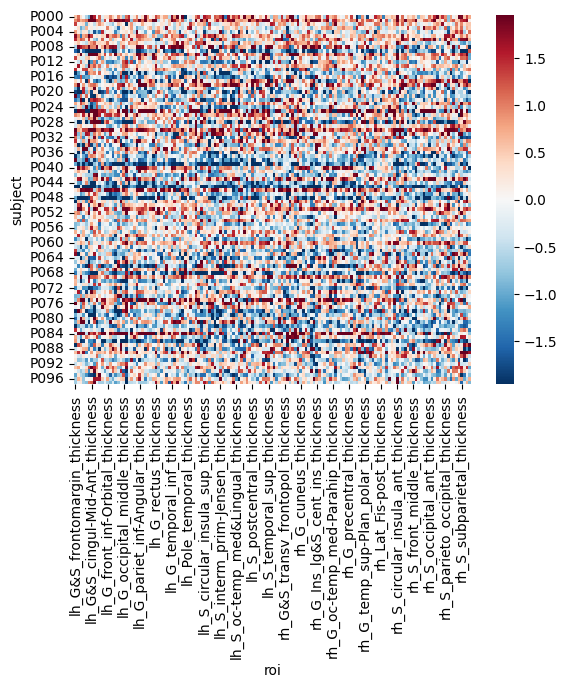

In [10]:
import seaborn as sns
sns.heatmap(pat_zdiff, vmin=-1.96, vmax=1.96, cmap='RdBu_r')

### Statistically test the median of z-diff scores against zero

<Axes: xlabel='P-value', ylabel='Count'>

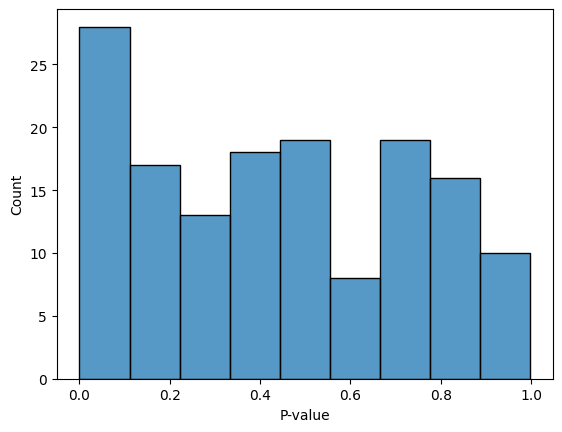

In [14]:
from scipy.stats import wilcoxon
import statsmodels.stats.multitest as multi

# Create empty lists to store the results
columns = []
w_statistics = []
p_values = []

# Loop through each column in the DataFrame
for column in pat_zdiff.columns:
    # Perform the Wilcoxon signed-rank test for the column against zero
    w_stat, p_value = wilcoxon(pat_zdiff[column], zero_method='zsplit')
    
    # Store the results in the lists
    columns.append(column)
    w_statistics.append(w_stat)
    p_values.append(p_value)

# Create a new DataFrame from the lists
wilcoxon_results = pd.DataFrame({'IDP': columns, 'W-statistic': w_statistics, 'P-value': p_values})

# Apply Benjamini-Hochberg correction to the p-values
wilcoxon_results['P-value_corrected'] = multi.multipletests(wilcoxon_results['P-value'], method='fdr_bh')[1]
wilcoxon_results = pd.DataFrame(wilcoxon_results)

# Plot the histogram of all pvalues to get an idea of the general trend
sns.histplot(data = wilcoxon_results, x='P-value')

In [12]:
# Print the significant regions
wilcoxon_results.loc[wilcoxon_results['P-value_corrected']<0.05]

,IDP,W-statistic,P-value,P-value_corrected
14,lh_G_front_middle_thickness,1518.0,0.001301,0.038505
88,rh_G_front_middle_thickness,1328.0,0.000101,0.007446
89,rh_G_front_sup_thickness,1498.0,0.001014,0.038505
126,rh_S_front_middle_thickness,1504.0,0.001093,0.038505
127,rh_S_front_sup_thickness,1181.0,0.000010,0.001530


# Tips

In cas eyou don't have enough controls for both adaptation procedures, you can drop the site-specific adaptation

**However!**
- You can not use the cross-sectional analysis, they are definitely wrong. The site-adaptation is linear and it shifts all z-scores systematically. However, for the difference of V2-V1, this offset evens out, so this step is technically redundant. In that case, you can either have more controls for the healthy variance estimation, or split it again and use the remaining controls for a group-level comparison.

**The way to do that**
- The way to skip the site-specific adaptation requires a bit of cheating in the procedure -- you can pretend that your sample actually belongs to one of the datasets that were used for training the models -- in that case, the pretrained offset is going to be used to adjust the z-scores. However, because we're not interested in the z-scores, we can then continue only using the Y, Yhat and S2 values.

- Below is the example on how to do that

In [54]:
# Load data
v1_pat = pd.read_csv(os.path.join(working_dir, 'data', 'NIMH_patients_v1.csv'), index_col=0)
v2_pat = pd.read_csv(os.path.join(working_dir, 'data', 'NIMH_patients_v2.csv'), index_col=0)
v1_pat.insert(v1_pat.columns.get_loc('sitenum')+1, 'visit', 'V1')
v2_pat.insert(v2_pat.columns.get_loc('sitenum')+1, 'visit', 'V2')
v1_pat.insert(v1_pat.columns.get_loc('sitenum')+1, 'class', 'patient')
v2_pat.insert(v2_pat.columns.get_loc('sitenum')+1, 'class', 'patient')


v1_con = pd.read_csv(os.path.join(working_dir, 'data', 'NIMH_controls_v1.csv'), index_col=0)
v2_con = pd.read_csv(os.path.join(working_dir, 'data', 'NIMH_controls_v2.csv'), index_col=0)
v1_con.insert(v1_con.columns.get_loc('sitenum')+1, 'visit', 'V1')
v2_con.insert(v2_con.columns.get_loc('sitenum')+1, 'visit', 'V2')
v1_con.insert(v1_con.columns.get_loc('sitenum')+1, 'class', 'control')
v2_con.insert(v2_con.columns.get_loc('sitenum')+1, 'class', 'control')

df = pd.concat([pd.concat([pd.concat([v1_pat,v2_pat], axis=0), v1_con]), v2_con])
df['site'] = 'ABCD_01'
df['sitenum'] = 1

df.reset_index(inplace=True)
df.rename(columns={'index':'ID'}, inplace=True)

In [35]:
# which data columns are covariates?
covariates = ['age', 'sex']

# Limits for cubic B-spline basis
xmin = -5
xmax = 100

# Absolute Z threshold above which a sample is considered to be an outlier (without fitting any model)
outlier_thresh = 7

# load the site IDs from the pretrained data (if you decide to change the pretrained models, don;t forget to also change site ids here)
with open(os.path.join(pretrained_dir, 'docs', 'site_ids_ct_82sites.txt')) as f:
    site_ids_pretrained = f.read().splitlines()

# load names from the Destrioux freesurfer parcellation atlas
with open(os.path.join(pretrained_dir,'docs','phenotypes_ct_lh.txt')) as f:
    idp_ids_lh = f.read().splitlines()
with open(os.path.join(pretrained_dir,'docs','phenotypes_ct_rh.txt')) as f:
    idp_ids_rh = f.read().splitlines()

idp_ids = idp_ids_lh + idp_ids_rh
idp_ids.remove('lh_MeanThickness_thickness')
idp_ids.remove('rh_MeanThickness_thickness')

# Which sites are present in our dataset?
site_ids_test = df['site'].unique()

### Train the models

In [37]:
os.makedirs(target_dir, exist_ok=True)

# For sanity checks, save the files into *.csv
df.to_csv(os.path.join(target_dir, 'all_data.csv'), sep=' ')

###
# The pretrained model coeffitients are stored individually for every IDP, so we need to cycle through them and apply the models
###
for iidp_no, iidp in enumerate(idp_ids):
    # Create folder for the particular IDP (in appropriate visit dir)
    idp_dir = os.path.join(target_dir, iidp)
    os.makedirs(idp_dir, exist_ok=True)
    os.chdir(idp_dir)
    # Assuming that the data used were a part of the original dataset on which the model was trained
    if all (elem in site_ids_pretrained for elem in site_ids_test):   
        
        print('The data are that are part of the original dataset')
        
        # Configure and save the design matrix
        design_matrix = create_design_matrix(df[covariates],
                                                site_ids = df['site'],
                                                all_sites = site_ids_pretrained,
                                                basis = 'bspline', xmin = xmin, xmax = xmax)
        np.savetxt(os.path.join(idp_dir, 'design_matrix.txt'), design_matrix)

        ###
        # Save responses
        ###
        np.savetxt(os.path.join(idp_dir, 'response.txt'), df[iidp].to_numpy())

        ###
        # Save sitenum
        ###
        np.savetxt(os.path.join(idp_dir, 'sitenum.txt'), df['sitenum'].to_numpy())

        ###
        # Actually run the model
        ###
        yhat, s2, Z, y = predict(os.path.join(idp_dir, 'design_matrix.txt'),
                                    respfile = os.path.join(idp_dir, 'response.txt'),
                                    alg='blr',
                                    model_path = os.path.join(pretrained_dir, 'models', 'lifespan_57K_82sites', iidp, 'Models'),
                                    return_y = True
                                    )
        
       

The data are that are part of the original dataset
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
The data are that are part of the original dataset
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
The data are that are part of the original dataset
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
The data are that are part of the original dataset
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
The data are that are part of the original dataset
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
The data are that are part of the original dataset
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Wr

### From now on, you can continue as in the original tutorial, don't forget to disentangle visits and classes
- you can check that if you use the same controls for the estimation of healthy variance (as in the original tutorial), the resulting z-diff scores of patients will be the same

In [53]:
# Concatenate the results across IDPs and remove the unnecessary folders
idp_concat(target_dir, 'Y_predict.txt', idp_ids, 'Y_predict_concat.txt', t_dir = target_dir)
idp_concat(target_dir, 'yhat_predict.txt', idp_ids, 'Yhat_predict_concat.txt', t_dir = target_dir)
idp_concat(target_dir, 'Z_predict.txt', idp_ids, 'Z_predict_concat.txt', t_dir = target_dir)
idp_concat(target_dir, 'ys2_predict.txt', idp_ids, 'Ys2_predict_concat.txt', t_dir = target_dir)

[shutil.rmtree(os.path.join(target_dir, d)) for d in idp_ids if os.path.isdir(os.path.join(target_dir, d))]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [88]:
# To make it easier, this is the code, which again concatenates data to xarray structures

for iclass in ['patient', 'control']:
    for ivisit in ['V1', 'V2']:

        idc_filter = df[(df['class'] == iclass) & (df['visit'] == ivisit)].index.to_numpy()

        pk = xr.concat([
                    xr.DataArray(pd.read_csv(os.path.join(target_dir, 'Y_predict_concat.txt'), sep=' ', index_col =0)[idp_ids].loc[idc_filter], [('subject', df.loc[idc_filter]['ID']), ('roi', idp_ids)]),
                    xr.DataArray(pd.read_csv(os.path.join(target_dir, 'Z_predict_concat.txt'), sep=' ', index_col =0)[idp_ids].loc[idc_filter], [('subject', df.loc[idc_filter]['ID']), ('roi', idp_ids)]),
                    xr.DataArray(pd.read_csv(os.path.join(target_dir, 'Yhat_predict_concat.txt'), sep=' ', index_col =0)[idp_ids].loc[idc_filter], [('subject', df.loc[idc_filter]['ID']), ('roi', idp_ids)]),
                    xr.DataArray(pd.read_csv(os.path.join(target_dir, 'Ys2_predict_concat.txt'), sep=' ', index_col =0)[idp_ids].loc[idc_filter], [('subject', df.loc[idc_filter]['ID']), ('roi', idp_ids)])
                    ], 
                    pd.Index(['Y', 'Z', 'Yhat', 'S2'], name='features')
                    )
        
        if ivisit == 'V1':
            temp=pk
        
        if iclass == 'patient':
            xr_pat2 = xr.concat([
                pk, temp
            ],
            pd.Index(['V1', 'V2'], name = 'visit'))
        
        if iclass == 'control':
            xr_con2 = xr.concat([
                pk, temp
            ],
            pd.Index(['V1', 'V2'], name = 'visit'))

con_clin2 = xr.concat([
        xr.DataArray(df[['age', 'sex', 'site']].loc[np.where(df[(df['class'] == 'control') & (df['visit'] == 'V1')]['ID'])], [('subject', df[(df['class'] == 'control') & (df['visit'] == 'V1')]['ID']), ('covariates', ['age', 'sex', 'site'])]),
        xr.DataArray(df[['age', 'sex', 'site']].loc[np.where(df[(df['class'] == 'control') & (df['visit'] == 'V2')]['ID'])], [('subject', df[(df['class'] == 'control') & (df['visit'] == 'V2')]['ID']), ('covariates', ['age', 'sex', 'site'])]),
        ],
        pd.Index(['V1', 'V2'], name='visit'))

pat_clin2 = xr.concat([
        xr.DataArray(df[['age', 'sex', 'site']].loc[np.where(df[(df['class'] == 'patient') & (df['visit'] == 'V1')]['ID'])], [('subject', df[(df['class'] == 'patient') & (df['visit'] == 'V1')]['ID']), ('covariates', ['age', 'sex', 'site'])]),
        xr.DataArray(df[['age', 'sex', 'site']].loc[np.where(df[(df['class'] == 'patient') & (df['visit'] == 'V2')]['ID'])], [('subject', df[(df['class'] == 'patient') & (df['visit'] == 'V2')]['ID']), ('covariates', ['age', 'sex', 'site'])]),
        ],
        pd.Index(['V1', 'V2'], name='visit'))

xr_pat2 = xr.merge([xr_pat2.to_dataset(name = 'neuroimaging'), pat_clin2.to_dataset(name ='clinics')])
xr_con2 = xr.merge([xr_con2.to_dataset(name = 'neuroimaging'), con_clin2.to_dataset(name ='clinics')])
